In [ ]:
%load_ext autoreload
%autoreload 2

# Token Classification: Training

> The `training.token_classification` module contains the core bits required for training transformers on token classification tasks (e.g., Named entity recognition (NER), Part-of-speech tagging (POS), etc...)

In [ ]:
# |default_exp training.token_classification
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import ast, gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from seqeval import metrics as seq_metrics
from transformers import logging as hf_logging

from blurr.data.core import first_blurr_tfm
from blurr.data.token_classification import TokenClassTextInput, get_token_labels_from_input_ids, get_word_labels_from_token_labels

In [ ]:
# |hide
import pdb, nbdev

from datasets import concatenate_datasets, load_dataset, Value
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, FuncSplitter, MultiCategoryBlock
from fastai.data.transforms import DataLoader, DataLoaders, Datasets, ItemTransform, TfmdDL
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.metrics import accuracy
from fastai.optimizer import Adam, params
from fastai.text.data import SortedDL
from fastcore.test import *

from blurr.data.core import *
from blurr.data.token_classification import *
from blurr.training.core import *
from blurr.utils import *

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `conll2003` to demonstrate how to configure your blurr code for token classification

In [ ]:
conll2003_dsd = load_dataset("conll2003")
conll2003_dsd

Found cached dataset conll2003 (/home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

We need to get a list of the distinct entities we want to predict. If they are represented as list in their raw/readable form in another attribute/column in our dataset, we could use something like this to build a sorted list of distinct values as such: 

`label_names = sorted(list(set([lbls for sublist in germ_eval_df.labels.tolist() for lbls in sublist])))`

Fortunately, the `conll2003` dataset allows us to get at this list directly using the code below.

In [ ]:
print(conll2003_dsd["train"].features["chunk_tags"].feature.names[:20])
print(conll2003_dsd["train"].features["ner_tags"].feature.names[:20])
print(conll2003_dsd["train"].features["pos_tags"].feature.names[:20])

['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP']
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS']


In [ ]:
print(conll2003_dsd["train"][0]["tokens"])
print(conll2003_dsd["train"][0]["ner_tags"])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [ ]:
label_names = conll2003_dsd["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Let's prepare both a Hugging Face `Dataset`s and `DataFrame`s for illustrating how each can be used in BLURR

In [ ]:
# build HF `Dataset` objects
train_ds = conll2003_dsd["train"].add_column("is_valid", [False] * len(conll2003_dsd["train"])).shuffle().select(range(1000))
valid_ds = conll2003_dsd["validation"].add_column("is_valid", [True] * len(conll2003_dsd["validation"])).shuffle().select(range(200))
conll2003_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
conll2003_df = pd.DataFrame(conll2003_ds)

print(len(train_ds), len(valid_ds))
print(len(conll2003_df[conll2003_df["is_valid"] == False]), len(conll2003_df[conll2003_df["is_valid"] == True]))
conll2003_df.head()

1000 200
1000 200


,id,tokens,pos_tags,chunk_tags,ner_tags,is_valid
0,11844,"[Stork, H1, results, breakdown, per, sector, .]","[22, 22, 24, 21, 15, 21, 7]","[11, 12, 12, 12, 13, 11, 0]","[3, 0, 0, 0, 0, 0, 0]",False
1,10089,"[world, track, cycling, championships, on, Wednesday, :]","[21, 21, 21, 24, 15, 22, 8]","[11, 12, 12, 12, 13, 11, 0]","[0, 0, 0, 0, 0, 0, 0]",False
2,772,"[CLEVELAND, 76, 51, .598, -]","[22, 11, 11, 11, 8]","[11, 12, 12, 12, 12]","[3, 0, 0, 0, 0]",False
3,434,"[52, ), v, Worcestershire, .]","[19, 5, 16, 22, 7]","[9, 0, 11, 12, 0]","[0, 0, 0, 3, 0]",False
4,5307,"[Results, of, South, Korean]","[24, 15, 16, 16]","[11, 13, 11, 12]","[0, 0, 7, 8]",False


## Base API


## Base API: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader`s

### PyTorch

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Dataset`s (PyTorch)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_train_ds = train_ds.map(tokenize_func, batched=True, remove_columns=train_ds.column_names)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True, remove_columns=valid_ds.column_names)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTokenClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTokenClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTokenClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

#### Step 3: `DataLoaders` (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


#### Step 5: Train

SuggestedLRs(minimum=0.004786301031708717, steep=5.248074739938602e-05, valley=0.0003311311302240938, slide=0.002511886414140463)

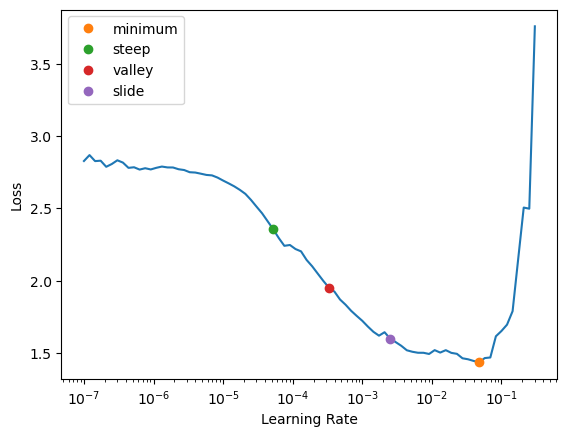

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.3452558219432831
valid_loss 0.34745579957962036
accuracy 0.25410446524620056


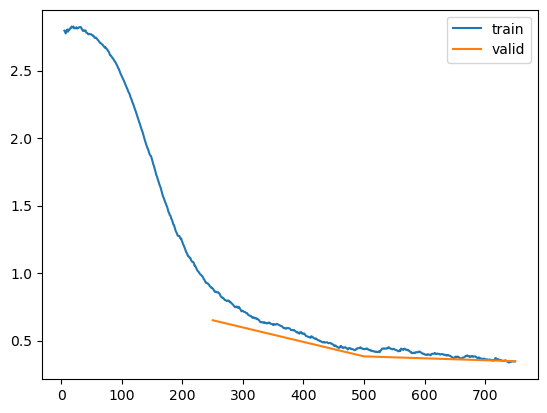

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (huggingface)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_train_ds = train_ds.map(tokenize_func, batched=True, remove_columns=train_ds.column_names)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True, remove_columns=valid_ds.column_names)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-b4890f921c441a46.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

##### Step 3: `DataLoaders` (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


#### Step 5: Train

SuggestedLRs(minimum=0.004786301031708717, steep=2.511886486900039e-05, valley=0.0005754399462603033, slide=0.0030199517495930195)

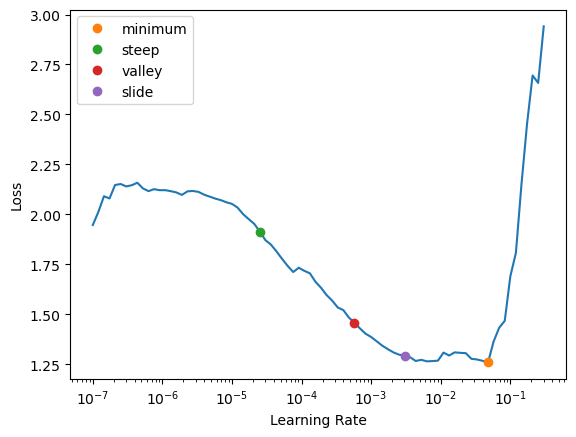

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.3156222999095917
valid_loss 0.3283638060092926
accuracy 0.25671640038490295


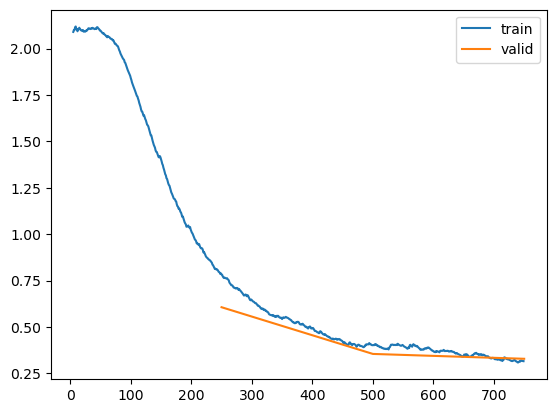

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

Most of the work to get things compliant with fast.ai's low-level API is already handed in the `data.token_classification` module. In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

In [ ]:
# |export
def calculate_token_class_metrics(pred_toks, targ_toks, metric_key):
    if metric_key == "accuracy":
        return seq_metrics.accuracy_score(targ_toks, pred_toks)

    if metric_key == "precision":
        return seq_metrics.precision_score(targ_toks, pred_toks)

    if metric_key == "recall":
        return seq_metrics.recall_score(targ_toks, pred_toks)

    if metric_key == "f1":
        return seq_metrics.f1_score(targ_toks, pred_toks)

    if metric_key == "classification_report":
        return seq_metrics.classification_report(targ_toks, pred_toks)

In [ ]:
nbdev.show_doc(calculate_token_class_metrics, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/token_classification.py#L34){target="_blank" style="float:right; font-size:smaller"}

### calculate_token_class_metrics

>      calculate_token_class_metrics (pred_toks, targ_toks, metric_key)

### `TokenClassMetricsCallback` -

In [ ]:
# |export
class TokenClassMetricsCallback(Callback):
    """
    A fastai friendly callback that includes accuracy, precision, recall, and f1 metrics using the
    `seqeval` library.  Additionally, this metric knows how to *not* include your 'ignore_token' in it's
    calculations.

    See [here](https://github.com/chakki-works/seqeval) for more information on `seqeval`.
    """

    def __init__(self, tok_metrics=["accuracy", "precision", "recall", "f1"], **kwargs):
        self.run_before = Recorder

        store_attr(self=self, names="tok_metrics, kwargs")
        self.custom_metrics_dict = {k: None for k in tok_metrics}

        self.do_setup = True

    def setup(self):
        # one time setup code here.
        if not self.do_setup:
            return

        # grab the hf_tokenizer from the TokenClassBatchTokenizeTransform
        tfm = first_blurr_tfm(self.learn.dls)
        self.hf_tokenizer = tfm.hf_tokenizer
        self.ignore_label_token_id = tfm.ignore_token_id
        self.tok_special_symbols = list(self.hf_tokenizer.special_tokens_map.values())
        self.tok_kwargs = tfm.kwargs

        # grab our label names
        self.trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
        if self.trg_labels is None and self.learn.dls.vocab is not None:
            self.trg_labels = self.learn.dls.vocab

        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys])
        self.learn.metrics = self.learn.metrics + custom_metrics
        self.learn.token_classification_report = None

        self.do_setup = False

    def before_fit(self):
        self.setup()

    # --- batch begin/after phases ---
    def before_batch(self):
        pass

    def after_batch(self):
        if self.training or self.learn.y is None:
            return

        # do this only for validation set
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0]  # yb is TensorText tuple, item 0 is the data

        preds_list, targets_list = [], []
        for i in range(targs.shape[0]):
            item_targs, item_preds = [], []

            for j in range(targs.shape[1]):
                if targs[i, j] != self.ignore_label_token_id:
                    item_preds.append(self.trg_labels[preds[i][j].item()])
                    item_targs.append(self.trg_labels[targs[i][j].item()])

            preds_list.append(item_preds)
            targets_list.append(item_targs)

        self.results += [(res[0], res[1]) for res in zip(preds_list, targets_list)]

    # --- validation begin/after phases ---
    def before_validate(self):
        self.results = []

    def after_validate(self):
        if len(self.results) < 1:
            return

        preds, targs = map(list, zip(*self.results))
        for k in self.custom_metrics_dict.keys():
            self.custom_metrics_dict[k] = calculate_token_class_metrics(targs, preds, metric_key=k)

        try:
            self.learn.token_classification_report = calculate_token_class_metrics(targs, preds, "classification_report")
        except ZeroDivisionError as err:
            print(f"Couldn't calcualte classification report: {err}")

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key):
        return self.custom_metrics_dict[metric_key]

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TokenClassTextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_arch, hf_tokenizer = tfm.hf_arch, tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
    if trg_labels is None and learner.dls.vocab is not None:
        trg_labels = learner.dls.vocab

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        trgs = y[idx]
        pred = outs[idx]
        sample = samples[idx] if samples is not None else None

        # align "tokens" with labels
        tok_labels = get_token_labels_from_input_ids(hf_tokenizer, input_ids, trgs, trg_labels)
        # align "words" with labels
        word_labels = get_word_labels_from_token_labels(hf_arch, hf_tokenizer, tok_labels)
        # align "words" with "predicted" labels
        if isinstance(pred[0], str):
            pred_labels = ast.literal_eval(pred[0])
        elif torch.is_tensor(pred[0]):
            pred_labels = [trg_labels[label_id] for label_id in list(pred[0].numpy())]

        word_pred_labels = [pred_lbl for lbl_id, pred_lbl in zip(trgs, pred_labels) if lbl_id != -100]
        # stringify list of (word,label) for example
        res.append(
            [
                f"{[ (word_targ[0], word_targ[1], pred_targ) for idx, (word_targ, pred_targ) in enumerate(zip(word_labels, word_pred_labels)) if (trunc_at is None or idx < trunc_at) ]}"
            ]
        )

    display_df(pd.DataFrame(res, columns=["token / target label / predicted label"])[:max_n])
    return ctxs

## Low-Level API: Examples

### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


### Step 2: `Datasets` (fastai)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)
tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_conll2003_ds = conll2003_ds.map(tokenize_func, batched=True)

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_conll2003_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(train_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

### Step 3: `DataLoaders` (fastai)

In [ ]:
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
batch_decode_tfm = BatchDecodeTransform(
    hf_tokenizer, hf_arch, hf_config, hf_model, label_names=label_names, input_return_type=TokenClassTextInput
)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    after_batch=batch_decode_tfm,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8, trunc_at=500)

,word / target label
0,"[('Stork', 'B-ORG'), ('H1', 'O'), ('results', 'O'), ('breakdown', 'O'), ('per', 'O'), ('sector', 'O'), ('.', 'O')]"
1,"[('Several', 'O'), ('other', 'O'), ('items', 'O'), ('have', 'O'), ('been', 'O'), ('reported', 'O'), ('found', 'O'), ('along', 'O'), ('the', 'O'), ('New', 'B-LOC'), ('Jersey', 'I-LOC'), ('shore', 'O'), (',', 'O'), ('most', 'O'), ('of', 'O'), ('it', 'O'), ('such', 'O'), ('personal', 'O'), ('items', 'O'), ('as', 'O'), ('wallets', 'O'), (',', 'O'), ('shoes', 'O'), ('and', 'O'), ('jewelry', 'O'), ('.', 'O')]"
2,"[('BUCHAREST', 'B-LOC'), ('1996-08-25', 'O')]"
3,"[('15,000', 'O'), ('.', 'O')]"


### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 84)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 84 x 768        
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 84 x 3072       
Linear                          

### Step 5: Train

SuggestedLRs(minimum=0.00014454397605732084, steep=7.585775892948732e-05, valley=0.00013182566908653826, slide=0.001737800776027143)

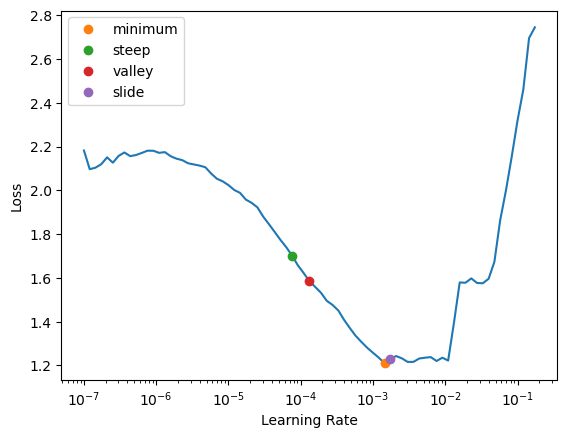

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.34009817242622375
valid_loss 0.32824820280075073
accuracy 0.25723883509635925


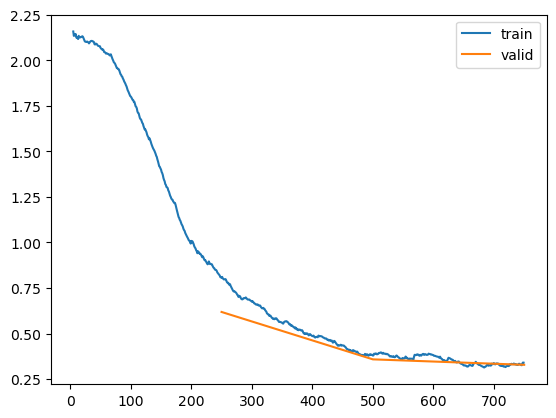

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

## Mid-Level API: Examples

### Pretokenized

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)

txt_block = TextBlock(
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    input_return_type=TokenClassTextInput,
    data_collator=data_collator,
    batch_decode_kwargs={"label_names": label_names},
)

blocks = (txt_block, noop)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

#### Step 3: `DataLoaders`

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)
tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_conll2003_ds = conll2003_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-8f1fe15222b9632d.arrow


In [ ]:
dls = dblock.dataloaders(proc_conll2003_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,word / target label
0,"[('Stork', 'B-ORG'), ('H1', 'O'), ('results', 'O'), ('breakdown', 'O'), ('per', 'O'), ('sector', 'O'), ('.', 'O')]"
1,"[('It', 'O'), ('was', 'O'), ('his', 'O'), ('fourth', 'O'), ('riding', 'O'), ('offence', 'O'), ('this', 'O'), ('season', 'O'), ('.', 'O')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 84)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 84 x 768        
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 84 x 3072       
Linear                          

#### Step 5: Train

SuggestedLRs(minimum=0.0002511886414140463, steep=7.585775892948732e-05, valley=6.30957365501672e-05, slide=5.248074739938602e-05)

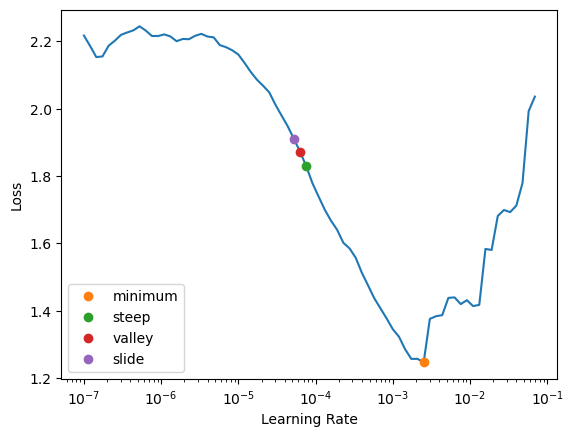

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5), cbs=[TokenClassMetricsCallback()])

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.348692923784256
valid_loss 0.3226734399795532
accuracy 0.9075144508670521
precision 0.4821917808219178
recall 0.5432098765432098
f1 0.5108853410740203


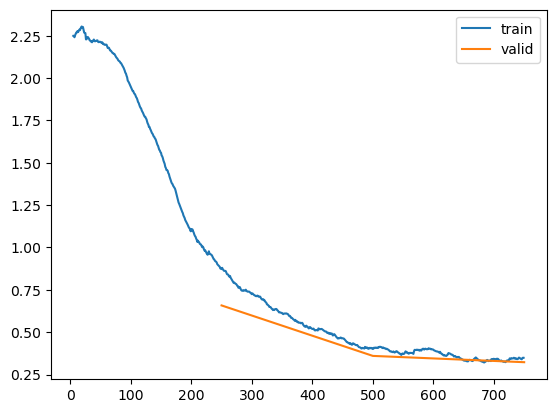

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('Cukaricki', 'B-ORG', 'B-ORG'), ('4', 'O', 'I-PER'), ('2', 'O', 'I-ORG'), ('0', 'O', 'O'), ('2', 'O', 'O'), ('6', 'O', 'O'), ('6', 'O', 'O'), ('6', 'O', 'O')]"
1,"[('I', 'O', 'O'), (""'ve"", 'O', 'O'), ('been', 'O', 'O'), ('fading', 'O', 'O'), ('my', 'O', 'O'), ('driver', 'O', 'O'), ('but', 'O', 'O'), ('today', 'O', 'O'), ('whenever', 'O', 'O'), ('I', 'O', 'O'), ('set', 'O', 'O'), ('up', 'O', 'O'), ('for', 'O', 'O'), ('a', 'O', 'O'), ('fade', 'O', 'O'), ('it', 'O', 'O'), ('went', 'O', 'O'), ('straight', 'O', 'O'), ('.', 'O', 'O')]"


In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = TokenClassBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, labeling_strategy_cls=BILabelingStrategy, target_label_names=label_names
)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm, input_return_type=TokenClassTextInput), TokenCategoryBlock(vocab=label_names))
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("tokens"),
    get_y=ColReader("ner_tags"),
    splitter=ColSplitter(),
)

In [ ]:
# |hide
# dblock.summary(conll2003_df)

#### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(conll2003_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,word / target label
0,"[('15', 'O'), ('-', 'O'), ('Christian', 'B-PER'), ('Cullen', 'I-PER'), (',', 'O'), ('14', 'O'), ('-', 'O'), ('Jeff', 'B-PER'), ('Wilson', 'I-PER'), (',', 'O'), ('13', 'O'), ('-', 'O'), ('Walter', 'B-PER'), ('Little', 'I-PER'), (',', 'O'), ('12', 'O'), ('-', 'O'), ('Frank', 'B-PER'), ('Bunce', 'I-PER'), (',', 'O'), ('11', 'O'), ('-', 'O'), ('Glen', 'B-PER'), ('Osborne', 'I-PER'), (';', 'O'), ('10', 'O'), ('-', 'O'), ('Andrew', 'B-PER'), ('Mehrtens', 'I-PER'), (',', 'O'), ('9', 'O'), ('-', 'O'), ('Justin', 'B-PER'), ('Marshall', 'I-PER'), (';', 'O'), ('8', 'O'), ('-', 'O'), ('Zinzan', 'B-PER'), ('Brooke', 'I-PER'), (',', 'O'), ('7', 'O'), ('-', 'O'), ('Josh', 'B-PER'), ('Kronfeld', 'I-PER'), (',', 'O'), ('6', 'O'), ('-', 'O'), ('Michael', 'B-PER'), ('Jones', 'I-PER'), (',', 'O'), ('5', 'O'), ('-', 'O'), ('Ian', 'B-PER'), ('Jones', 'I-PER'), (',', 'O'), ('4', 'O'), ('-', 'O'), ('Robin', 'B-PER'), ('Brooke', 'I-PER'), (',', 'O'), ('3', 'O'), ('-', 'O'), ('Olo', 'B-PER'), ('Brown', 'I-PER'), (',', 'O'), ('2', 'O'), ('-', 'O'), ('Sean', 'B-PER'), ('Fitzpatrick', 'I-PER'), ('(', 'O'), ('captain', 'O'), (')', 'O'), (',', 'O'), ('1', 'O'), ('-', 'O'), ('Craig', 'B-PER'), ('Dowd', 'I-PER'), ('.', 'O')]"
1,"[('Innocent', 'B-PER'), ('Butare', 'I-PER'), (',', 'O'), ('executive', 'O'), ('secretary', 'O'), ('of', 'O'), ('the', 'O'), ('Rally', 'B-ORG'), ('for', 'I-ORG'), ('the', 'I-ORG'), ('Return', 'I-ORG'), ('of', 'I-ORG'), ('Refugees', 'I-ORG'), ('and', 'I-ORG'), ('Democracy', 'I-ORG'), ('in', 'I-ORG'), ('Rwanda', 'I-ORG'), ('(', 'O'), ('RDR', 'B-ORG'), (')', 'O'), ('which', 'O'), ('says', 'O'), ('it', 'O'), ('has', 'O'), ('the', 'O'), ('support', 'O'), ('of', 'O'), ('Rwanda', 'B-LOC'), (""'s"", 'O'), ('exiled', 'O'), ('Hutus', 'B-MISC'), (',', 'O'), ('appealed', 'O'), ('to', 'O'), ('the', 'O'), ('international', 'O'), ('community', 'O'), ('to', 'O'), ('deter', 'O'), ('the', 'O'), ('two', 'O'), ('countries', 'O'), ('from', 'O'), ('going', 'O'), ('ahead', 'O'), ('with', 'O'), ('what', 'O'), ('it', 'O'), ('termed', 'O'), ('a', 'O'), ('""', 'O'), ('forced', 'O'), ('and', 'O'), ('inhuman', 'O'), ('action', 'O'), ('""', 'O'), ('.', 'O')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 84)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 84 x 768        
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 84 x 3072       
Linear                          

#### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=4.365158383734524e-05, valley=0.00010964782268274575, slide=0.0012022644514217973)

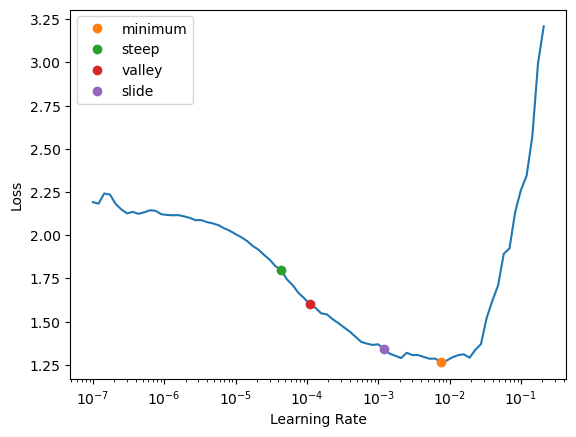

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5), cbs=[TokenClassMetricsCallback()])

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.40166881680488586
valid_loss 0.3868822157382965
accuracy 0.8988439306358381
precision 0.4767123287671233
recall 0.5704918032786885
f1 0.5194029850746268


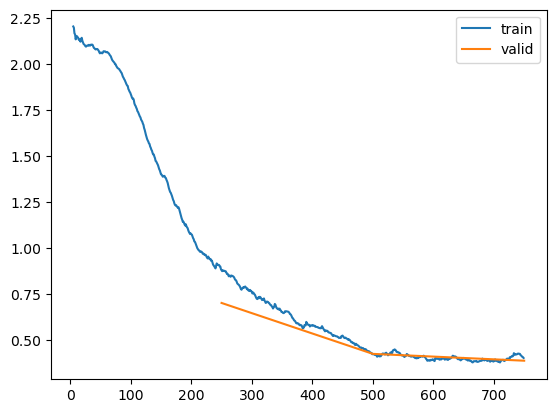

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('Aziz', 'B-PER', 'B-PER'), ('said', 'O', 'O'), ('Iraq', 'B-LOC', 'B-LOC'), (""'s"", 'O', 'O'), ('military', 'O', 'O'), ('intervention', 'O', 'O'), (',', 'O', 'O'), ('the', 'O', 'O'), ('first', 'O', 'O'), ('on', 'O', 'O'), ('such', 'O', 'O'), ('scale', 'O', 'O'), ('since', 'O', 'O'), ('the', 'O', 'O'), ('U.S.', 'B-LOC', 'O'), ('and', 'O', 'O'), ('allies', 'O', 'O'), ('decided', 'O', 'O'), ('to', 'O', 'O'), ('protect', 'O', 'O'), ('Iraqi', 'B-MISC', 'O'), ('Kurds', 'I-MISC', 'O'), ('against', 'O', 'O'), ('Baghdad', 'B-LOC', 'O'), (',', 'O', 'O'), ('was', 'O', 'O'), ('in', 'O', 'O'), ('response', 'O', 'O'), ('to', 'O', 'O'), ('a', 'O', 'O'), ('plea', 'O', 'O'), ('from', 'O', 'O'), ('Barzani', 'B-PER', 'O'), ('to', 'O', 'O'), ('President', 'O', 'O'), ('Saddam', 'B-PER', 'O'), ('Hussein', 'I-PER', 'B-ORG'), ('to', 'O', 'O'), ('back', 'O', 'O'), ('him', 'O', 'O'), ('militarily', 'O', 'O'), ('and', 'O', 'O'), ('save', 'O', 'O'), ('his', 'O', 'O'), ('people', 'O', 'O'), ('from', 'O', 'O'), ('attacks', 'O', 'O'), ('by', 'O', 'O'), ('Iran', 'B-LOC', 'O'), ('and', 'O', 'O'), ('Talabani', 'B-PER', 'O'), ('.', 'O', 'O')]"
1,"[('""', 'O', 'O'), ('All', 'O', 'O'), ('concerned', 'O', 'O'), ('must', 'O', 'O'), ('avoid', 'O', 'O'), ('taking', 'O', 'O'), ('any', 'O', 'O'), ('course', 'O', 'O'), ('of', 'O', 'O'), ('action', 'O', 'O'), ('that', 'O', 'O'), ('could', 'O', 'O'), ('pose', 'O', 'O'), ('an', 'O', 'O'), ('obstacle', 'O', 'O'), ('to', 'O', 'O'), ('the', 'O', 'O'), ('peace', 'O', 'O'), ('process', 'O', 'O'), ('and', 'O', 'O'), ('which', 'O', 'O'), ('could', 'O', 'O'), ('make', 'O', 'O'), ('a', 'O', 'O'), ('peaceful', 'O', 'O'), ('solution', 'O', 'O'), ('difficult', 'O', 'O'), (',', 'O', 'O'), ('""', 'O', 'O'), ('he', 'O', 'O'), ('said', 'O', 'O'), (',', 'O', 'O'), ('as', 'O', 'O'), ('news', 'O', 'O'), ('came', 'O', 'O'), ('of', 'O', 'O'), ('a', 'O', 'O'), ('renewed', 'O', 'O'), ('breakdown', 'O', 'O'), ('in', 'O', 'O'), ('Arab-Israeli', 'B-MISC', 'O'), ('peace', 'O', 'O'), ('talks', 'O', 'O'), ('in', 'O', 'O'), ('Jerusalem', 'B-LOC', 'O'), ('.', 'O', 'O')]"


In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()